# APS1070
#### Lab 2 - Anomaly Detection Algorithm using Gaussian Mixture Model 
**Deadline: Feb 14, 23:59 - 10 points**

Please fill out the following:


*   Name: Sai Anirudh Basamsetty
*   Student Number:

##**Marking Scheme:**

This project is worth **10 marks** of your final grade.

**One (1) mark** of the lab is dedicated to **vectorized coding**. If you need to write a loop in your solution, think about how you can implement the same functionality with vectorized operations. Try to avoid loops as much as possible (in some cases loops are inevitable).

This notebook is composed of two sections, a Tutorial, and an Exercise. 

The TAs in the lab will help you to complete your tutorial (Although no mark is assigned to the **tutorial** compeleting that section is **mandatory**). 

**The exercise** section is worth **9 points**.

##**Important Note:**

1] Please **write answers** for the Tutorial & Exercise in the **blanks provided**.

2] Start lab early so that you understand concepts in Tutorial well & get enough time to implement exercise  

3] It is important to **complete and run the tutorial part** of the notebook. Make sure you complete both, tutorial as well as exercise part.
 
4] Provide a graphical representation of data wherever necessary.  


##Tutorial

In this part of the assignment, we will implement an anomaly detection algorithm using the Gaussian model to detect anomalous behavior in a 2D dataset first and then a high-dimensional dataset.

Loading relevant libraries and the dataset

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


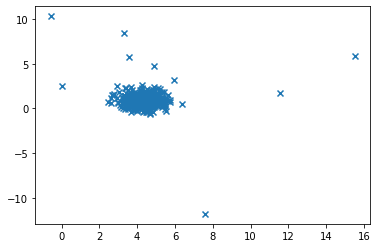

In [0]:
import numpy as np
import matplotlib.pyplot as plt


from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=1,
                       cluster_std=0.60, random_state=0)
X_append, y_true_append = make_blobs(n_samples=10,centers=1,
                                    cluster_std=5,random_state=0)
X = np.vstack([X,X_append])
y_true = np.hstack([y_true, [1 for _ in y_true_append]])
X = X[:, ::-1] # flip axes for better plotting
plt.scatter(X[:,0],X[:,1],marker="x");

Here we've manufactured a dataset where some points are visibly outliers from the main distribution.

We can see this from looking at the plot, but how do we robustly identify the outliers? 

That's where a Gaussian estimation comes in. For this dataset, we only need a single Gaussian, for which we are gonna calculate the mean and standard deviation. Then, we're able to find the points that don't seem likely to have originated from that distribution - these are our outliers!

First, we need to calculate the mean and variance for our data. Complete the function below to generate these values using these formulas:

$$\mu = \frac{1}{m} \sum_{i=1}^{m}X_i$$

$$\sigma^2 = \frac{1}{m} \sum_{i=1}^{m}(X_i-\mu)^2$$

In [0]:
def estimateGaussian(X):
    """
     This function estimates the parameters of a Gaussian distribution using the data in X
    """
    
    m = X.shape[0]
    
    #compute mean of X
    sum_ = np.sum(X,axis=0)
    mu =  (sum_/m)
    
    # compute variance of X
    var = (np.sum((X - mu)**2, axis = 0))/m
    
    return mu,var
mu, sigma2 = estimateGaussian(X)

Now, we will calculate for each point in X, the probability of the distribution $N(\mu,\sigma^2)$ generating that point randomly. This has been completed for you, although it is important to understand how the calculation of the PDF works.

In [0]:
def multivariateGaussian(X, mu, sigma2):
    """
    Computes the probability density function of the multivariate gaussian distribution.
    """
    k = len(mu)
    
    sigma2=np.diag(sigma2)
    X = X - mu.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(sigma2)**0.5))* np.exp(-0.5* np.sum(X @ np.linalg.pinv(sigma2) * X,axis=1))
    return p
p = multivariateGaussian(X, mu, sigma2)

Now that we have the probability of each point in the dataset, we can plot these on the original scatterplot:

In [0]:
plt.figure(figsize=(8,6))
plt.scatter(X[:,0],X[:,1],marker="x",c=p,cmap='viridis');
plt.colorbar();

We're getting closer to the point where we can programmatically  identify our outliers for a single Gaussian distribution. The last step is to identify a value for $p$, below which we consider a point to be an outlier. We term this $\epsilon$.

In [0]:
#Choose a value for epsilon

epsilon = 0.02

Now we'll highlight on the scatter plot all points that are below $\epsilon$:

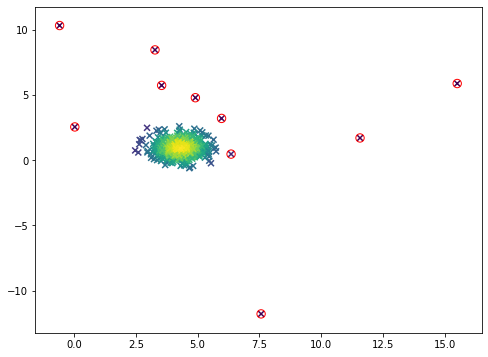

In [0]:
plt.figure(figsize=(8,6))
plt.scatter(X[:,0],X[:,1],marker="x",c=p,cmap='viridis');
# Circling of anomalies
outliers = np.nonzero(p<epsilon)[0]
plt.scatter(X[outliers,0],X[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);

What value of epsilon did you choose? Why? **I chose epsilon=0.02 as all the odd values outside the cluster are sorted out.**

Play around with different values until you're happy with the plot above. 

We can additionally look at our model's classification performance another way. By sorting the points ascending by their probability, and classifying the first $k$ points as anomalous, we can determine the model's precision@k. Implement this in the cell below. 

* What is the highest value of K for which we get a precision of 1.0? **The highest value of k is 10**
* What is the precision for K=4? **Precision: 1, Recall: 0.4**

In [0]:
from sklearn.metrics import precision_score ,recall_score
import pandas as pd


def sort_and_predict(p, y_true, K = [1,10,100]):
    # Initializing values
    precision_scores = np.zeros((len(K),3)) # Final Table of precision/recall scores

    # Storing the indices of the sorted p
    sorted_indices = np.argsort(p)

    # Sorting the probabilities in ascending order
    sorted_p = np.sort(p)

    # Sorting the predictions according to probabilities
    sorted_y_true = y_true[sorted_indices]

    # Looping through k
    for count, k in enumerate(K):
        y_pred = np.zeros((len(p),)) # Generating a prediction vector
        y_pred[:k] = 1 # Anomaly
        y_pred[k:] = 0 # Not anomaly
        precision_scores[count,0] = k
        precision_scores[count,1] = precision_score(sorted_y_true, y_pred)
        precision_scores[count,2] = recall_score(sorted_y_true, y_pred)

    return pd.DataFrame(precision_scores, columns = ['k','Precision','Recall']).set_index('k')

sort_and_predict(p, y_true, K = list(range(1,100)))







,Precision,Recall
k,,
1.0,1.000000,0.1
2.0,1.000000,0.2
3.0,1.000000,0.3
4.0,1.000000,0.4
5.0,1.000000,0.5
...,...,...
95.0,0.105263,1.0
96.0,0.104167,1.0
97.0,0.103093,1.0


You may have noticed that in this example, we are training and testing on the _entire_ dataset. This is absolutely not standard practice! You should _always_ split into a training and testing set. However, the reason that we can get away with this here is that we don't actually use labels at all during training - this is an _unsupervised_ machine learning task. Unsupervised learning methods are beneficial for anomaly detection because in the real world (i.e. testing!) we might come across types of outliers that we didn't see during training. We want to use a method that can handle this, and unsupervised methods are often better suited to this type of domain.

For the next section, we'll move to a Mixture of Gaussian models. Take a look at the following dataset:

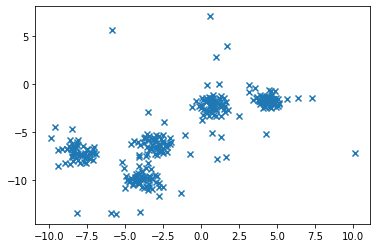

In [0]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
X, y_true = make_blobs(n_samples=400, centers=5,
                       cluster_std=0.60, random_state=1)
X_append, y_true_append = make_blobs(n_samples=50,centers=5,
                                    cluster_std=5,random_state=1)
X = np.vstack([X,X_append])
y_true = np.hstack([[0 for _ in y_true], [1 for _ in y_true_append]])
X = X[:, ::-1] # flip axes for better plotting

X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.33, random_state=1, shuffle=True)

plt.scatter(X_train[:,0],X_train[:,1],marker="x");

Okay, we have more than one cluster centre now. So what? Let's just ignore that and use the same model as before. 

* What is the precision for k=1 in the cell below? **Precision score is 1.00**
* k=10? **Precision score is 0.90 and recall score is 0.50**
* k=100? **Precision score is 0.13 and recall score is 0.722**

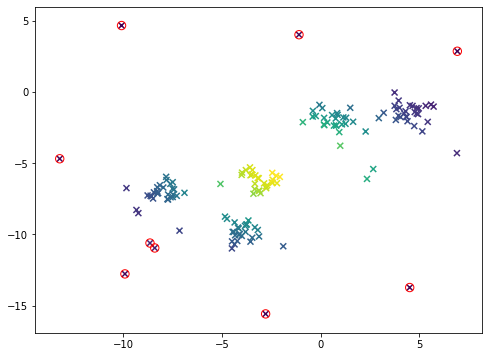

In [0]:
mu, sigma2 = estimateGaussian(X_train)
p = multivariateGaussian(X_test, mu, sigma2)
plt.figure(figsize=(8,6))
plt.scatter(X_test[:,0],X_test[:,1],marker="x",c=p,cmap='viridis');
outliers = np.nonzero(p<0.001)[0]
plt.scatter(X_test[outliers,0],X_test[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);


In [0]:
sort_and_predict(p, y_test, K = [1,10,100])

,Precision,Recall
k,,
1.0,1.00,0.055556
10.0,0.90,0.500000
100.0,0.13,0.722222


Uh oh. This model performs terribly. It's fit the mean to a section of space where we don't have _any_ points, and it has absolutely no idea which points are outliers! This was probably pretty obvious to you though. We need to move to a Mixture of Gaussians model - one in which we use multiple Gaussians to fit the data. We'll use `sklearn.mixture.GaussianMixture` to do this - or rather you will! Use the documentation, found [here](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture) to initialise and fit a `GaussianMixture` object called `gm` in the cell below.

In [0]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components = 5,
                    covariance_type = 'full', random_state=0,  )
gm.fit(X_train)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=5, n_init=1, precisions_init=None,
                random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

Now we can use the method `gm.score_samples()` which gives a score based on how likely a point is to have been generated by any cluster:

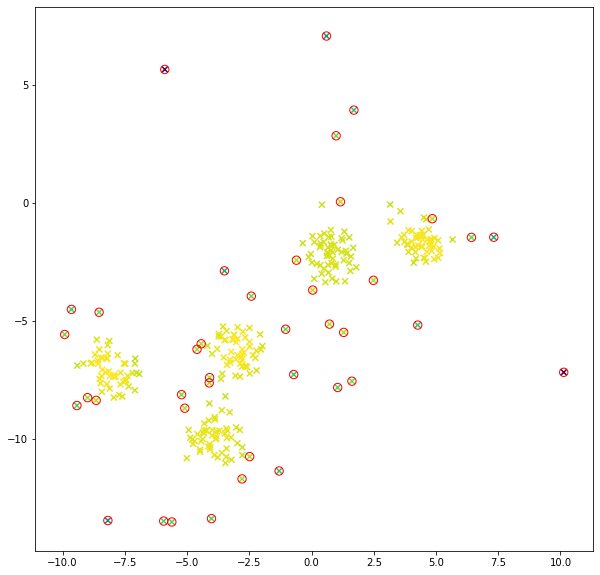

In [0]:
plt.figure(figsize=(10,10))
c = gm.score_samples(X_train)
plt.scatter(X_train[:,0],X_train[:,1],c=gm.score_samples(X_train),cmap='viridis',marker='x')

threshold= -4.8

outliers = np.nonzero(c<threshold)[0]
plt.scatter(X_train[outliers,0],X_train[outliers,1],marker="o",facecolor= "none",edgecolor="r",s=70)

What is the variable "`threshold`"? **EM iterations will stop when the lower bound average gain is below this threshold.**
 
 
 Why is it negative? **The points that are to be filtered are mostly negative**
 
Now we can use the method `gm.predict_proba()` to spot the points in each of the clusters.

In [0]:
Non_Outliers=np.nonzero(c>=threshold)[0]
X_t=X_train[Non_Outliers]
print(gm.predict_proba(X_train))
print(gm.score_samples(X_t))

[[3.32032178e-011 4.40166043e-009 3.18952155e-011 6.74869931e-059
  9.99999996e-001]
 [9.99999997e-001 1.29319813e-119 2.14816399e-009 1.93712936e-015
  1.19215143e-009]
 [7.32070993e-004 2.83317796e-056 9.99266986e-001 1.34738997e-013
  9.42624363e-007]
 ...
 [4.96241137e-012 1.41218398e-007 1.32754039e-012 1.98450900e-062
  9.99999859e-001]
 [1.74883538e-021 9.99282358e-001 9.26527784e-034 1.59058143e-109
  7.17641787e-004]
 [2.82750636e-020 9.74932585e-001 3.62991363e-029 2.22050746e-101
  2.50674150e-002]]
[-4.17649083 -3.51699613 -3.66046779 -4.17037173 -4.13690423 -3.23218358
 -3.80763763 -3.4222668  -4.18441578 -3.17229053 -3.84099701 -4.12698981
 -3.84504974 -3.37261619 -3.94206657 -3.25055041 -4.55754813 -4.26240418
 -3.67979038 -3.5286204  -4.17661908 -4.17850787 -4.65067984 -3.23213568
 -4.20096053 -3.99798884 -4.14013116 -3.2981905  -3.94567493 -4.3371146
 -4.14993318 -4.32886761 -4.59001642 -3.30940836 -4.13913447 -4.02558726
 -3.49963565 -3.04436382 -4.45531007 -3.8744889

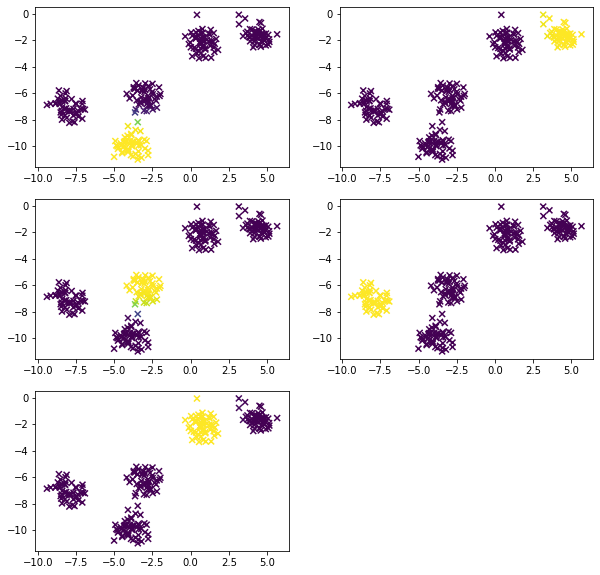

In [0]:
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(3,2,i+1)
    plt.scatter(X_t[:,0],X_t[:,1],c=gm.predict_proba(X_t)[:,i],cmap='viridis',marker='x')

1] What do functions `gm.score_samples()` and `gm.predict_proba()` return? **The density of the model at a given location is computed by gm.score_samples() and gm.predict_proba() predicts posterior probability of each component given the data**

2] Why it was important to run them in above sequence? **The classify the data into clusters and to spot the points in each clusters.**

3] What is the difference between the two function?**gm.predict is used to to find the probability of each point being part of any of the five clusters. and gm.score_samples returns the PDF of samples.**


Our Mixture of Gaussians model is powerful! Not only is it unsupervised, it can both classify points into one of the K clusters we have, _and_ it can help us with our ultimate goal of identifying outlier points! We can do this by finding the points that no cluster wants to claim for itself.

In the cell below, complete the code and calculate these values and then compute precision@k for k=1, 10, and 100. The ROC curve code has been completed for you. 

* Is this model better or worse performing than the previous? **This model performs better**
* Why might that be? **We cannot use one normal distribution as we have clustered data. So a mixture of multiple gaussians must be used to fit the clusters. Each cluster will have a normal distribution and so we can calculate the probablity that a point is outside all of the clusters. If we fit a single Gaussian, we might predict points between clusters to not be anomalous because we're only fitting one clustered data to one distribution.**

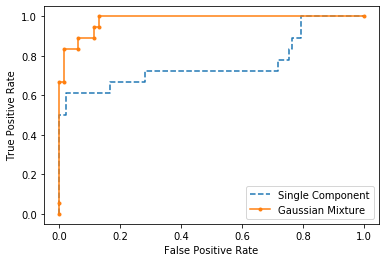

In [0]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

#This part outputs the precision and recall on the test set

#score_samples will compute the weighted log probabilities for each sample
p_gm = gm.score_samples(X_test) 

#Complete code below
for i in []: 
   #sort the points by probability, as before
   mn_gm = gm.predict_proba(X_test)
   #compare y_test labels to our picks using precision
   precision =  precision_score(y_test, X_test)
    
   #compare y_test labels to our picks using recall
   recall =  recall_score(y_test,X_test)
   #print precision and recall three times
   print()

#This part computes the ROC curves for both models like we talked about in class

from sklearn.metrics import roc_curve
from matplotlib import pyplot
fpr_sc, tpr_sc, _ = roc_curve(y_test, 1-p)
fpr_gm, tpr_gm, _ = roc_curve(y_test, 1-p_gm)
pyplot.plot(fpr_sc, tpr_sc, linestyle = '--', label='Single Component')
pyplot.plot(fpr_gm, tpr_gm, marker='.', label='Gaussian Mixture')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()


Let's look at a dataset that motivates using a Mixture of Gaussians model: Simpsons ratings.

Everyone knows that there's a certain point when The Simpsons "got bad", but can we use a Mixture of Gaussians to find out exactly when that was?

Load up the `simpsons.pickle` file using the cell below. It contains the IMDb rating for every simpsons episode.

In [0]:
!wget https://github.com/alexwolson/APS1070_data/raw/master/simpsons.pickle
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
with open('simpsons.pickle','rb') as f:
    simpsons = pickle.load(f)

--2020-03-12 08:51:39--  https://github.com/alexwolson/APS1070_data/raw/master/simpsons.pickle
Resolving github.com (github.com)... 13.250.177.223
Connecting to github.com (github.com)|13.250.177.223|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alexwolson/APS1070_data/master/simpsons.pickle [following]
--2020-03-12 08:51:45--  https://raw.githubusercontent.com/alexwolson/APS1070_data/master/simpsons.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26076 (25K) [application/octet-stream]
Saving to: ‘simpsons.pickle’

simpsons.pickle     100%[===================>]  25.46K  --.-KB/s    in 0s      

2020-03-12 08:51:45 (59.3 MB/s) - ‘simpsons.pickle’ saved [26076/26076]



In [0]:
simpsons = dict(sorted(list(simpsons.items()), key=lambda x: x[0]))

In [0]:
# Extracting ratings into a nunmpy array
ratings = np.array([])
for value in simpsons.values():
  ratings = np.append(ratings, list(value.values()))

Plot a histogram of the rating distribution for all Simpsons episodes. 

* What is the modal rating? **7.1**
* What is the range of ratings? **5.300000000000001**

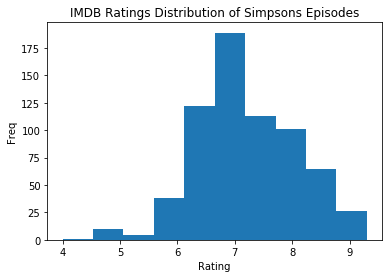

Modal Rating: 7.1
Range of Ratings: 5.300000000000001


In [0]:
from scipy.stats import mode

fig = plt.hist(ratings)
plt.title('IMDB Ratings Distribution of Simpsons Episodes')
plt.xlabel('Rating')
plt.ylabel('Freq')
plt.show()

print("Modal Rating:", mode(ratings)[0][0])
print("Range of Ratings:", ratings.max() - ratings.min())

Next, use Gaussian Mixture to fit a Mixture of Gaussians to the Simpsons rating distribution. Since we are trying to distinguish between good and bad ratings, we only need 2 gaussians.

* What are the means for the two Gaussians fit by the model? Bad: **6.7859272, Good: 8.20449347**
* What about the standard deviations? **Bad: 0.60218053, Good: 0.45788767**

In [0]:
gm = GaussianMixture(n_components = 2,
                    covariance_type = 'full', random_state=0, )
gm.fit(ratings.reshape(-1,1))

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=1, precisions_init=None,
                random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [0]:
print("Means:",gm.means_[:,0])
print("Standard Deviations:", np.sqrt(gm.covariances_[:,0][:,0]))

Means: [6.7859272  8.20449347]
Standard Deviations: [0.60218053 0.45788767]


Finally, using the `GuassianMixture.predict()` method, we can use maximum likelihood to estimate which distribution, good or bad, each episode belongs to. In the cell below, we have provided code to count the number of episodes predicted to be in the "good" distribution per season, and plot for the same.
Understand the code and answer the question.

* Where is the notable drop-off point? **Season 9**
* What is the first season with 0 good episodes? **Season 15**


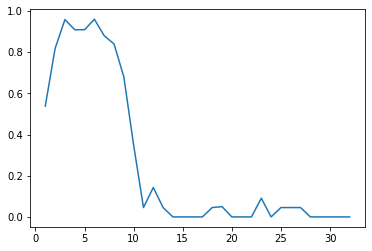

In [0]:

if gm.means_[0,0] > gm.means_[1,0]:
     Good_season_index = 0
else:
     Good_season_index = 1

Xs = []
Ys = []
simpsons = dict(sorted(list(simpsons.items()), key=lambda x: x[0]))
for season, episodes in simpsons.items():
     bad = 0
     good = 0
     for episode in episodes.values():
          if gm.predict(np.array(
               episode
          ).reshape(-1,1)) == Good_season_index:
               good += 1
          else:
               bad += 1
     Xs.append(season)
     Ys.append(good/(good+bad))
plt.plot(Xs,Ys);

## Exercises

Now we are going to work with a credit card fraud dataset (more detail can be found [here](https://www.kaggle.com/mlg-ulb/creditcardfraud/downloads/creditcardfraud.zip/3)). This dataset contains 28 key features, which are not 
directly interpretable but contain meaningful information about the dataset.

Load up the dataset in CSV file using Pandas. The dataset is called `creditcard.csv`. Print out the first few columns of the dataset.

* How many rows are there?[0.5] **284807**
* What features in the dataset are present aside from the 28 main features?[0.5] **Class, Amount , Time**
* Why do you think the main features are given to us in this way?[0.5]   **The features were generated using a PCA analysis. The features might contain some confidential information, they are given in this way so that all users cannot understand. Perhaps 1000's of features might have been compressed using PCA analysis hence making less number of features making it easy to distribute and improve security**
* Which column contains the targets? Can you figure out what the values correspond to?[0.5] **Class Column contains the targets. 0 is non fradulent, 1 is fradulent. Fradulence is bad**

In [0]:
pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=9379381f6f64348214d2b029d3084a040d4fa1087fdc9c35687a7c27d99866f4
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [0]:
import wget

wget.download('https://github.com/alexwolson/APS1070_data/raw/master/creditcard.tar.gz','creditcard.tar.gz')

In [0]:
!tar -zxvf creditcard.tar.gz

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
df = pd.read_csv('creditcard.csv')
df



In [0]:
df.describe()

In [0]:
print(df.head())
print("Rows:", df.shape[0])
print(df.columns)
print(df['Class'].value_counts())

In [0]:
print(df['Class'].value_counts()*100/df.shape[0])

It's always important when looking at a new dataset to figure out how many rows we have for each class.

* What is the percentage of entries in the dataset for each class?[0.5] **99.827251% non-fradulent, 0.172749% fradulent**
* Is this target data balanced or unbalanced? why do you think this is so?[0.5]**The given target data is unbalanced as the number of fradulent cases is less than the number of non-fradulent cases**
* Why might this pose a problem when methods we have looked at so far?[1]   **Splitting into a training and test set might pose a problem, we cannot have sufficient number of fradulent examples to train and test our model.**



Next, split the dataset into a training and testing set. Use a test size of one third, and set the random state to 0.

Make sure to separate out the column corresponding to the targets.

As mentioned earlier, in this lab we are going to use Gaussian distributions to model the data. To accomplish this, we are going to introduce `scipy`, a package which contains a wide variety of tools for working with scientific data in Python. Its `stats` package allows us to easily model various statistical distributions, and get information about them.

Scipy's Gaussian distribution class is called `norm`. It takes two parameters - `loc`, which corresponds to the mean of your distribution, and `scale`, which corresponds to the standard deviation.

* What are the mean and standard deviation for variable V24? Make sure to only use your training set for this. [1] **Mean:0.0004296701611641686 ; Standard Deviation: 0.6048294388274841**

Use the code below to set up a Gaussian object for V24.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,0:-1], df['Class'], test_size = 1/3, random_state = 0, shuffle = True)

In [0]:
from scipy import stats

norm = stats.norm(
    loc = X_train['V24'].mean(),
    scale = X_train['V24'].std()
)
print("Mean:",X_train['V24'].mean())
print("Standard Deviation:", X_train['V24'].std())


In [0]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(1, 1)
x = np.linspace(norm.ppf(0.01),
                norm.ppf(0.99), 100)
ax.plot(x, norm.pdf(x),
       'r-', lw=5, alpha=0.6, label='norm pdf')
ax.hist(X_train['V24'].values, density=True, histtype='stepfilled', bins=50);
plt.show()

We can also look at the difference in distribution for some variables between fraudulent and non-fraudulent transactions:

In [0]:
import matplotlib.gridspec as gridspec
import seaborn as sns
features=[f for f in df.columns if 'V' in f]
nplots=np.size(features)
plt.figure(figsize=(15,4*nplots))
gs = gridspec.GridSpec(nplots,1)
for i, feat in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.distplot(X_train[feat][y_train==1], bins=30)
    sns.distplot(X_train[feat][y_train==0],bins=30)
    ax.legend(['fraudulent', 'non-fraudulent'],loc='best')
    ax.set_xlabel('')
    ax.set_title('Distribution of feature: ' + feat)

1] Build an outlier detection model using a Mixture of Gaussians using five features with a large difference in distribution between fraudulent and non-fraudulent data. Report the precision and recall @k for k=1, 10 and 100 (on test data). Repeat this model creation process, this time selecting five features with a of your own choice, and reporting the precision and recall as above. [2]

**The tables for precision and recall score are shown below each iteration**

2] What features did you choose for each model? What effect it had on the model performance? [1]
**I picked the following features:
V4,
V11,
V12,
V14,
V16,
V17.
I chose these features to start with because these features had minimal histogram overlap between fraudulent versus not fraudulent data.**



3] Organize your findings in a table or plot and describe your findings. What can you conclude about what models work best?[1] 

**Lower number of components, less overlapped distributions work best.**

In [0]:
import matplotlib.pyplot as plt


def model_selection_process(df, compare, n_components, features_selected, random_state = 0, ks_tested = [1, 5, 10, 15, 25, 50, 75, 100]):
  fig = plt.figure(figsize=(20,15))
  fig, ax_lst = plt.subplots(1, 2)
  
  final = pd.DataFrame()
  
  if compare == "n":
    for n in n_components:
      X_train, X_test, y_train, y_test = train_test_split(df[features_selected], df['Class'], train_size = 2/3, random_state=random_state)
      gm = GaussianMixture(n_components = n, covariance_type = 'full', random_state=random_state)
      gm.fit(X_train)
      p_gm = gm.score_samples(X_test)
      test = sort_and_predict(p_gm, np.array(y_test), K = ks_tested )
      ax_lst[0].plot(test['Precision'], label = f"n = {n}")
      ax_lst[1].plot(test['Recall'], label = f"n = {n}")
      test.columns = pd.MultiIndex.from_tuples([(f"n_components = {n}", "Precision"), (f"n_components = {n}", "Recall")])
      final = pd.concat([final,test], axis = 1)
    ax_lst[0].legend()
    ax_lst[1].legend()
    ax_lst[0].title.set_text("Precision Versus K")
    ax_lst[1].title.set_text("Recall Versus K")
    ax_lst[0].set_ylim([0,1])
    ax_lst[1].set_ylim([0,1])
    fig.suptitle(f"Features Selected: {features_selected}")
  
  elif compare == "features":
    for features in features_selected:
      X_train, X_test, y_train, y_test = train_test_split(df[features], df['Class'], train_size = 2/3, random_state=random_state)
      gm = GaussianMixture(n_components = n_components, covariance_type = 'full', random_state=random_state)
      gm.fit(X_train)
      p_gm = gm.score_samples(X_test)
      test = sort_and_predict(p_gm, np.array(y_test), K = ks_tested)
      ax_lst[0].plot(test['Precision'], label = f"feature_set = {features}")
      ax_lst[1].plot(test['Recall'], label = f"feature_set = {features}")
      test.columns = pd.MultiIndex.from_tuples([(f"features = {features}", "Precision"), (f"features = {features}", "Recall")])
      final = pd.concat([final,test], axis = 1)
    ax_lst[0].legend()
    ax_lst[1].legend()
    ax_lst[0].title.set_text("Precision Versus K")
    ax_lst[1].title.set_text("Recall Versus K")
    ax_lst[0].set_ylim([0,1])
    ax_lst[1].set_ylim([0,1])
    fig.suptitle(f"N_Components Selected: {n_components}")   
    
  return fig, final.loc[[1,10,100], :]

In [0]:
i1 = model_selection_process(df,  compare = "n", n_components = [2,3,4,5,6], features_selected = ['V4','V11','V12','V14','V16','V17'])

In [0]:
display(i1)

Based on my first iteration, performance (in terms of precision and recall) improves as we decrease the number of components. Furthermore, it seems like n=2 performs best for precision and recall because the graph is equal to or higher than all the other choices for n_components.

What I noticed in the histograms earlier was that V4 and V11 had similar distributions (fradulent data to the right of non-fradulent) while V12, V14, V16, V17 had similar distributions (fraduelent data to the left of nan-fraudulent). It would be interesting to compare the [V4, V11] pair to the [V12, V14, V16, V17] pair for the next iteration for n = 2.

#### Iteration 2

In [0]:
i2 = model_selection_process(df, features_selected = [['V4', 'V11'],['V12', 'V14', 'V16', 'V17']], n_components = 2, compare = 'features')

In [0]:
display(i2)

We notice that having fradulent data to the right of non-fradulent (V4,V11) performs almost equal to or worse than having fradulent data to the left of non-fradulent (V12, V14, V16, V17) in terms of recall for all k values tested. 

In terms of precision, low values of k have a much higher precision when using the V4, V11 feature set, but this changes as k increases. 

Also, we notice that precision is much higher than recall on average. Hence, we need to focus a bit more on choosing our model to maximize recall because we want to be able to correctly predict fradulent cases.

Hence, it seems like V12, V14, V16, V17 pair would be the better option to continue with at this stage.

It would be interesting to remove V16 and V17 because they show a lot more overlap than V12 and V14. We can compare them on the next iteration for n = 2

#### Iteration 3

In [0]:
i3 = model_selection_process(df, compare = "features", n_components = 2, features_selected = [['V12', 'V14'], ['V16', 'V17']])

In [0]:
display(i3)

V12, V14 feature set performs approximately equal to or better than the V16, V17 feature set on both precision and recall for all k values tested. Hence, we will continue with the V12, V14 feature set.

We will finally test this for 1, 2, 3 and 4 components because there were some similarities in performance earlier for different values of n_components, particularly 2 or 3 components. We'll also look at 1 component because we overlooked that in the earlier iterations.

#### Iteration 4


In [0]:
i4 = model_selection_process(df, compare = "n", n_components = [1,2,3,4], features_selected = ['V12', 'V14'])

In [0]:
display(i4)

#### Final Model Performance

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df[['V12','V14']], df['Class'], train_size = 2/3, random_state=0)
gm = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
gm.fit(X_train)
p_gm = gm.score_samples(X_test)
test = sort_and_predict(p_gm, np.array(y_test), K = [1, 5, 10, 15, 25, 50, 75, 100])

In [0]:
display(test.loc[[1,10,100]])

We have a recall score of 0.51 and a precision score of 0.84 for k=100
Ultimately we can conclude that,features with lower number of components and less overlapped distributions work best.